# Workshop 5

Jesus Ramirez Delgado

A01274723

In [ ]:
import requests
import pandas as pd
# Code to download the IGAE index from the INEGI site:
token = 'c4559227-83d3-aeb4-1a8d-bee73f627140'

igae_id = '737121'

url =  f'https://www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/INDICATOR/{igae_id}/es/0700/false/BIE/2.0/{token}?type=json'

response = requests.get(url)
data = response.json()
series = data.get('Series', [])
observations = series[0].get('OBSERVATIONS', [])
igaedf = pd.DataFrame(observations)
# Convert the month to a date type variable:
igaedf['TIME_PERIOD'] = pd.to_datetime(igaedf['TIME_PERIOD'], format='%Y/%m')
# Convert the IGAE index to a numeric variable:
igaedf['OBS_VALUE'] = pd.to_numeric(igaedf['OBS_VALUE'], errors='coerce')
# Keep only the columns we need
igaedf = igaedf[['TIME_PERIOD', 'OBS_VALUE']]
# Rename the columns:
igaedf.columns = ['Month', 'IGAE']
# Setting the month as the index of the series:
igaedf = igaedf.set_index('Month')
# Sorting the data according to the index:
igaedf = igaedf.sort_index()
# Display the first few rows
print(igaedf.tail())


                  IGAE
Month                 
2025-04-01  104.159225
2025-05-01  107.920457
2025-06-01  105.277425
2025-07-01  105.839766
2025-08-01  105.137197


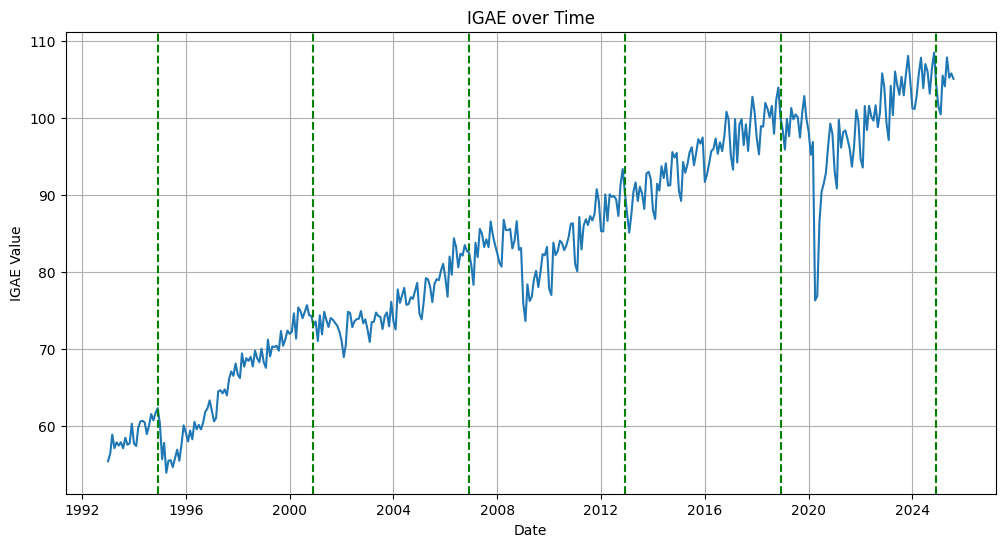

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(igaedf.index, igaedf['IGAE'])
plt.title('IGAE over Time')
plt.xlabel('Date')
plt.ylabel('IGAE Value')
plt.grid(True)

# Trace vertical lines to identify the 6-year government periods
plt.axvline(pd.to_datetime('1994-12-01'), color='green', linestyle='--')
plt.axvline(pd.to_datetime('2000-12-01'), color='green',linestyle='--')
plt.axvline(pd.to_datetime('2006-12-01'), color='green',linestyle='--')
plt.axvline(pd.to_datetime('2012-12-01'), color='green',linestyle='--')
plt.axvline(pd.to_datetime('2018-12-01'), color='green',linestyle='--')
plt.axvline(pd.to_datetime('2024-12-01'), color='green',linestyle='--')

plt.show()

## Stationary vs No Stationary

Just like most averagle time series this is a Non-stationary time series, so in this part we will:

1. Apply the log to the IGAE(Y) in order to reduce the scale or the relative variance and see if now we have a stationary behaviour but I'll tell you in advance that it's not like that.
2. Now we apply the first difference to the series and now we already get an stationary time series.
3. In order to confirm we apply the Dicky-Fuller test.

### Apply Log to IGAE

Applying the log we now get a scale and change the magnitude of the endogeneous variable, is almost sure that we will not see a difference because we are just "smoothing" the scale but is highly recommended do always this step in statistics.

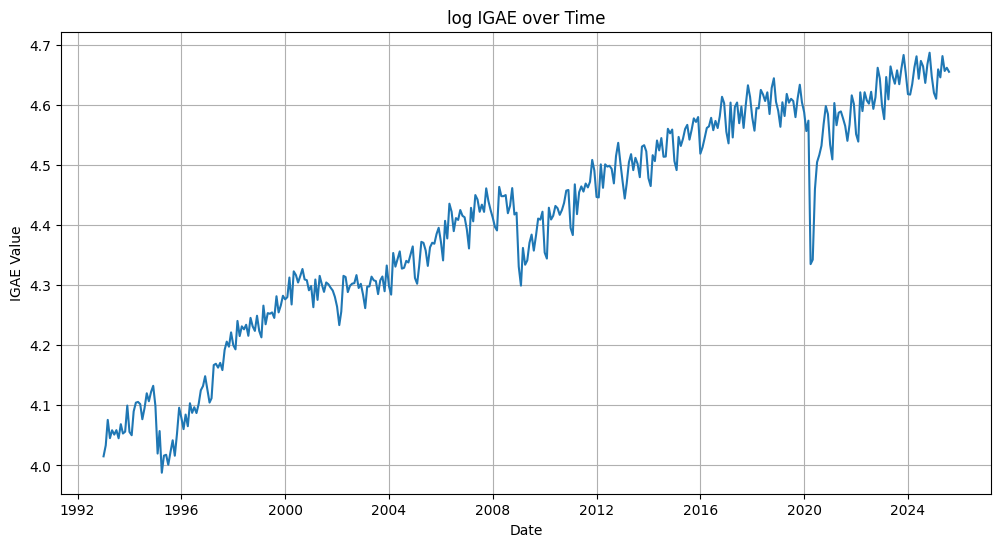

In [ ]:
import numpy as np
igaedf['logIGAE'] = np.log(igaedf['IGAE'])

plt.figure(figsize=(12, 6))
plt.plot(igaedf.index, igaedf['logIGAE'])
plt.title('log IGAE over Time')
plt.xlabel('Date')
plt.ylabel('IGAE Value')
plt.grid(True)
plt.show()

### Seasonal Log Difference

Let’s see why the seasonal log difference is the annual % change of the series:

diff(logigae,12) = logigae - lag(logigae,12)

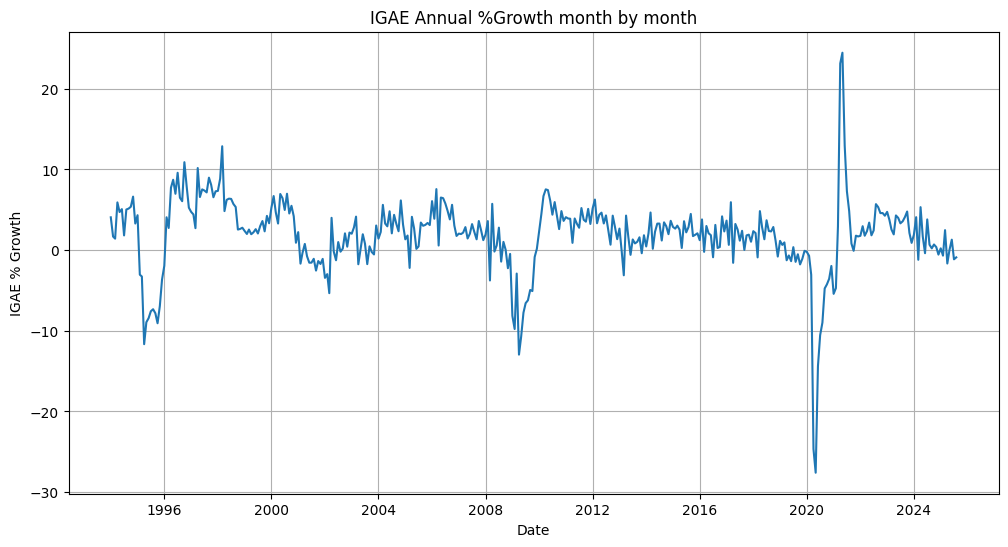

In [ ]:
igaedf['annualgrowth'] = igaedf['logIGAE'] - igaedf['logIGAE'].shift(12)
# We can also do this annual growth by using the diff function:
# igaedf['annualgrowth2'] = igaedf['logIGAE'].diff(12)

plt.figure(figsize=(12, 6))
plt.plot(igaedf.index, 100*igaedf['annualgrowth'])
plt.title('IGAE Annual %Growth month by month')
plt.xlabel('Date')
plt.ylabel('IGAE % Growth')
plt.grid(True)
plt.show()

In [ ]:
# !pip install statsmodels
from statsmodels.tsa.stattools import adfuller

dftest = adfuller(igaedf['annualgrowth'].dropna())

# Print the results
print('ADF Statistic: %f' % dftest[0])

print('p-value: %f' % dftest[1])

print('Critical Values:')

for key, value in dftest[4].items():
  print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.962962
p-value: 0.001617
Critical Values:
	1%: -3.448
	5%: -2.869
	10%: -2.571


The result P-value<0.005 of the Dicky-Fuller Test indicate us that the hypothesis can be rejected so this series can be treated as stationary.

### Autocorrelations (AC) and Partial-autocorrelations (PAC)

After decide which stationary variable we will use, we need to examine correlations and autocorrelations with, for this we will use an correlogram.

In time series analysis, a correlogram is an chart of correlation statistics also known as an autocorrelation plot. This is a plot of the sample autocorrelations of the dependent variable Yt and the time lags. In R, the function to compute the autocorrelations is acf2() from the astsa package, which gives you both, the autocorrelation (ACF) figures and the partial-autocorrelations (PACF), as well.

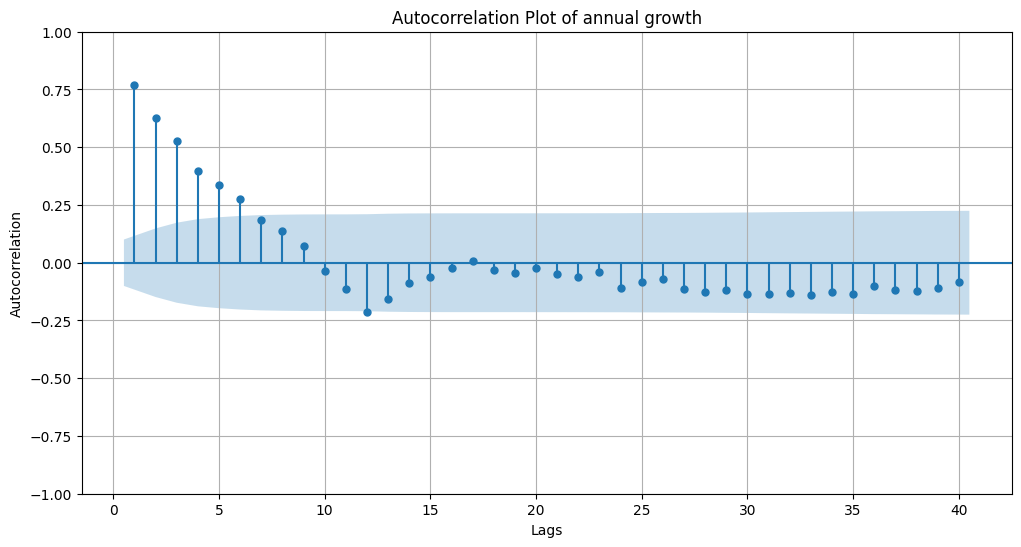

In [ ]:
# prompt: Using igaedf, Do an autocorrelation plot and a partial autocorrelation plot of 'annualgrowth'

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Drop NaN values created by the differencing
annual_growth = igaedf.dropna(subset=['annualgrowth'])

# Autocorrelation plot
plt.figure(figsize=(12, 6))
plot_acf(annual_growth['annualgrowth'], lags=40, zero=False, ax=plt.gca())
plt.title('Autocorrelation Plot of annual growth')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

In this chart we can see that almost whole observations have not significative correlation, just first 6 lags are significatives.

For the first Lag we can see that  has an average autocorrelation about 0.80 with its own value at t-1.

If we see this effect of the first lag and then the following lags are decreasing until they are not significative correlated, this means that the model has an effect of long term memory.

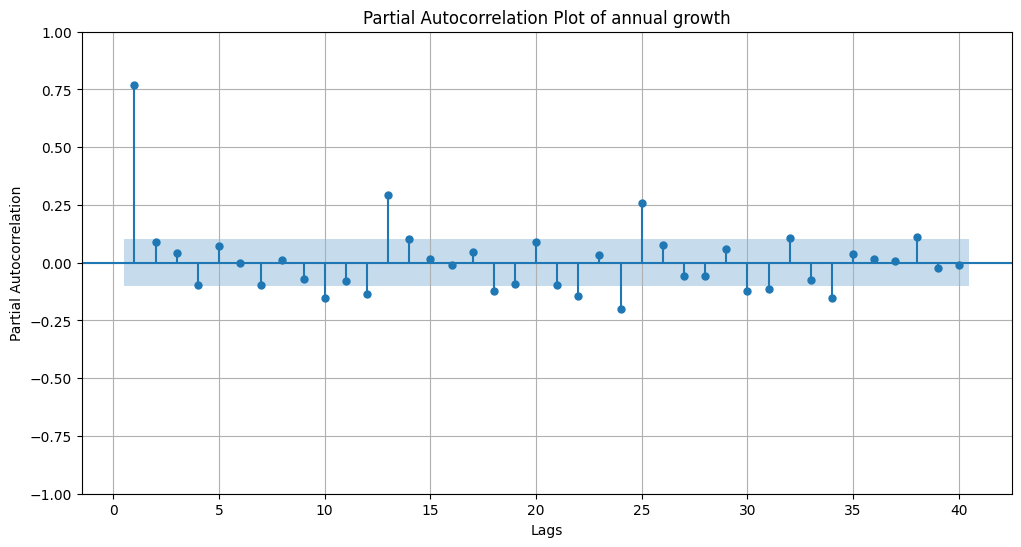

In [ ]:
# Partial autocorrelation plot
plt.figure(figsize=(12, 6))
plot_pacf(annual_growth['annualgrowth'], zero=False, lags=40, ax=plt.gca())
plt.title('Partial Autocorrelation Plot of annual growth')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.grid(True)
plt.show()

In this plot we get the correlations with the correlation of the first lag and the with the last lag, so basically each this is calculaated with last lag and then the last lag of the last lag, etc... So each shift are against each othor to explicated meaining, that's why the next lags from the first are not significateive correlated. And in the next year or period

## Calibrating the ARIMA-SARIMA models

The objective of the calibration of an ARIMA-SARIMA model is to find the right values for p, d, q, P, D and Q.


The values for d and D are already defined when we found the transformation of the variable that became stationary. In this case, we found that the seasonal difference of the log of IGAE is stationary, so the parameters for d and D are:

d=0; D=1

The next steps are:

1. Find the best values for p and q. Remember:
  - p = Number of parameters for AR(p).
  - q = nUMBER OF parameters for MA(a).

There are two possible initial value for p and q:

### AR signature

- Initial values: p = 1, 2 or 3. | q = 0.
- AC Plot: An AR signature can be observed when the AC Plot shows positive autocorrelations for the first lags and gradually decay over time.
- PAC Plot: PAC autocorrelations show 1, 2 or 3 positive and significant autocorrelations that drastically decay after few lags.
- When we have an AR signature, the best configuration for p = number of significant autocorrelations in the PAC Plot, and the value for q is set to zero (q=0).

### MA Signature

- Initial values: p = 0. | q = 1, 2 or 3.
- PAC Plot: Autocorrelations decay more gradually than AR signature PAC plot.
- AC andPAC: Both have negative vert few significant autocorrelated, usually 1.
- When we have MA signature the best configurations is q = number of significant autocorrelations, 1 = 0.

### After calubrate p and q

1. Now we run a SARIMA ARIMA model with values of P and Q setted both to 0.
2. Get phi0 and phi1 values

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

igae_log = igaedf['logIGAE'].dropna()

# Fit SARIMA model ARIMA(p=1,d=0,q=0) SARIMA(P=0,D=1,Q=0,#periods=12)
model = SARIMAX(igae_log, order=(1, 0, 0),
                seasonal_order=(0, 1, 0, 12),
                trend='c') # Include drift/constant term
result = model.fit()
print(result.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                            logIGAE   No. Observations:                  392
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 12)   Log Likelihood                 801.153
Date:                            Thu, 13 Nov 2025   AIC                          -1596.306
Time:                                    05:11:45   BIC                          -1584.486
Sample:                                01-01-1993   HQIC                         -1591.616
                                     - 08-01-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0043      0.002      2.859      0.004       0.001       0.007
ar.L1          0.7694      0.021   

In [ ]:
phi0 = result.params['intercept']
phi1= result.params['ar.L1']

print('phi0 = intercept = %f' % phi0)
print('phi1 = %f' % phi1)

phi0 = intercept = 0.004334
phi1 = 0.769374


We can se that both are possitive significative since their p-value is less than 0.005.



### White noise

The next step is check if the errors (residuals) looks like white noise.

White nose: Whice noise is a time series that has not significative autocorrelatios with its own lags.

1. Do a AC PAC plot of the residuals

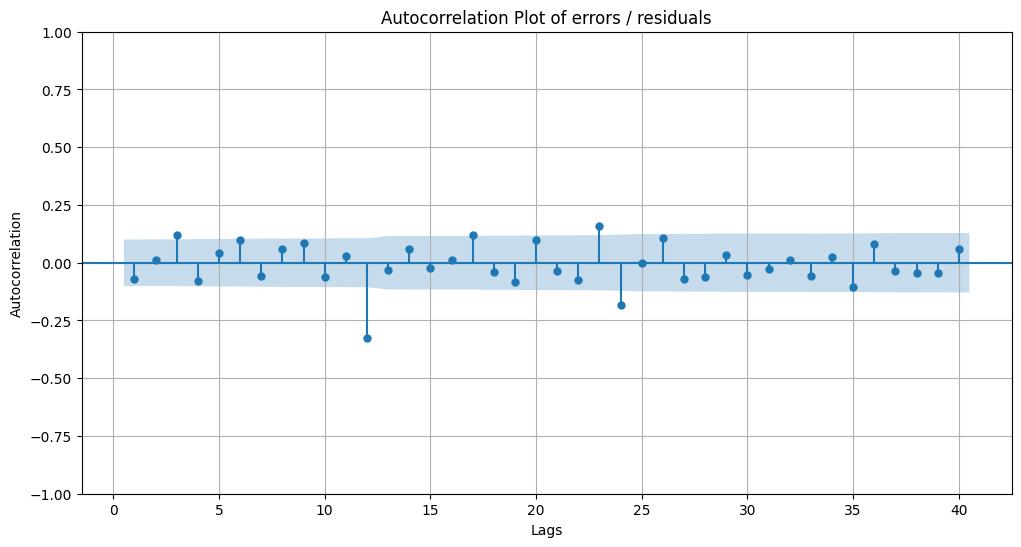

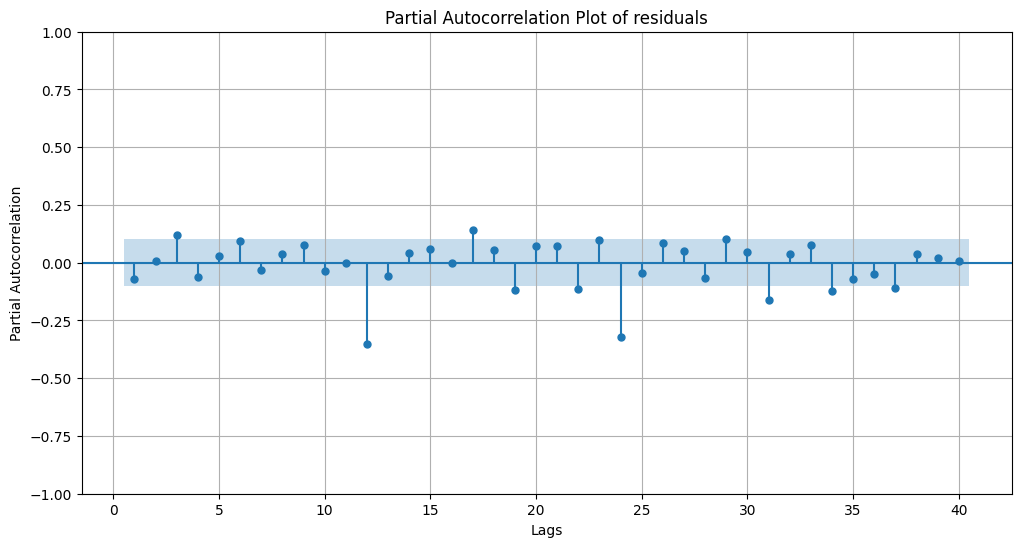

In [ ]:
# Autocorrelation plot
plt.figure(figsize=(12, 6))
plot_acf(result.resid.iloc[12:], lags=40, zero=False, ax=plt.gca())
plt.title('Autocorrelation Plot of errors / residuals')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

# Partial autocorrelation plot
plt.figure(figsize=(12, 6))
plot_pacf(result.resid.iloc[12:], zero=False, lags=40, ax=plt.gca())
plt.title('Partial Autocorrelation Plot of residuals')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.grid(True)
plt.show()

We see that in both plots, the AC and the PAC plot, the autocorrelation of the residuals with its own lag 12 is negative and significant.means that we can incorporate in the model a seasonal term P=1 or Q=1 to account for this significant autocorrelation.

Rule of thumb: when this happens, if the significant autocorrelation is negative in both plots, we start selecting a seasonal MA term and NO AR terms. In other words, we start setting the values for P and Q as:

P = 0

Q = 1

2. Run the model the new values of P and Q.

In [ ]:
igae_log = igaedf['logIGAE'].dropna()

# Fit SARIMA model ARIMA(p=1,d=0,q=0) SARIMA(P=0,D=1,Q=1,#periods=12)
model = SARIMAX(igae_log, order=(1, 0, 0),
                seasonal_order=(0, 1, 1, 12),
                trend='c') # Include drift/constant term
result = model.fit()
print(result.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                              logIGAE   No. Observations:                  392
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 12)   Log Likelihood                 864.452
Date:                              Thu, 13 Nov 2025   AIC                          -1720.904
Time:                                      05:11:49   BIC                          -1705.144
Sample:                                  01-01-1993   HQIC                         -1714.650
                                       - 08-01-2025                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0026      0.000      6.752      0.000       0.002       0.003
ar.L1          0.86

In [ ]:
phi0 = result.params['intercept']
phi1= result.params['ar.L1']
theta1 = result.params['ma.S.L12']

print('phi0 = intercept = %f' % phi0)

print('phi1 = %f' % phi1)

print('theta1 = %f' % theta1)


phi0 = intercept = 0.002591
phi1 = 0.861471
theta1 = -0.817436


We can note again that the terms of phi and theta are autocorrelated since their p-values is less than 0.005

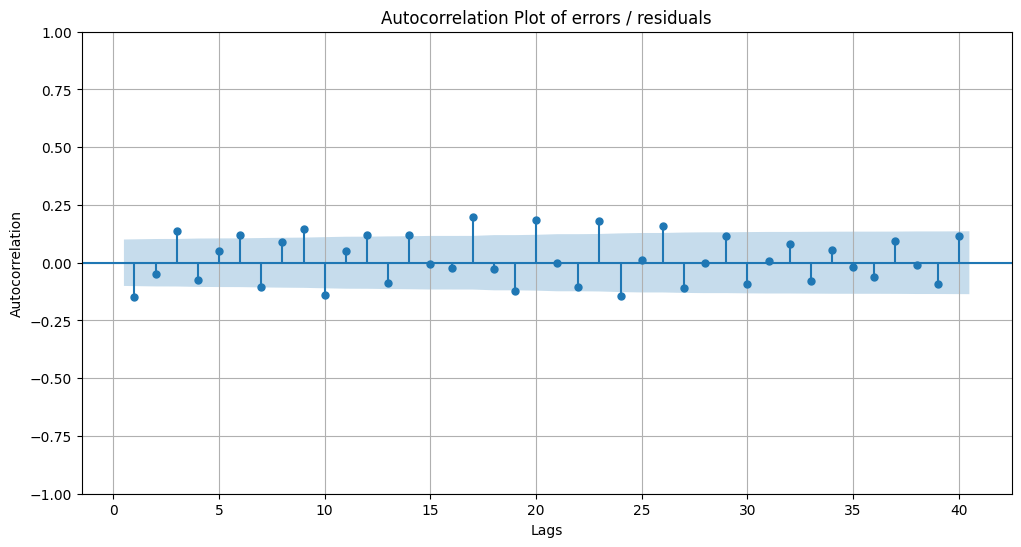

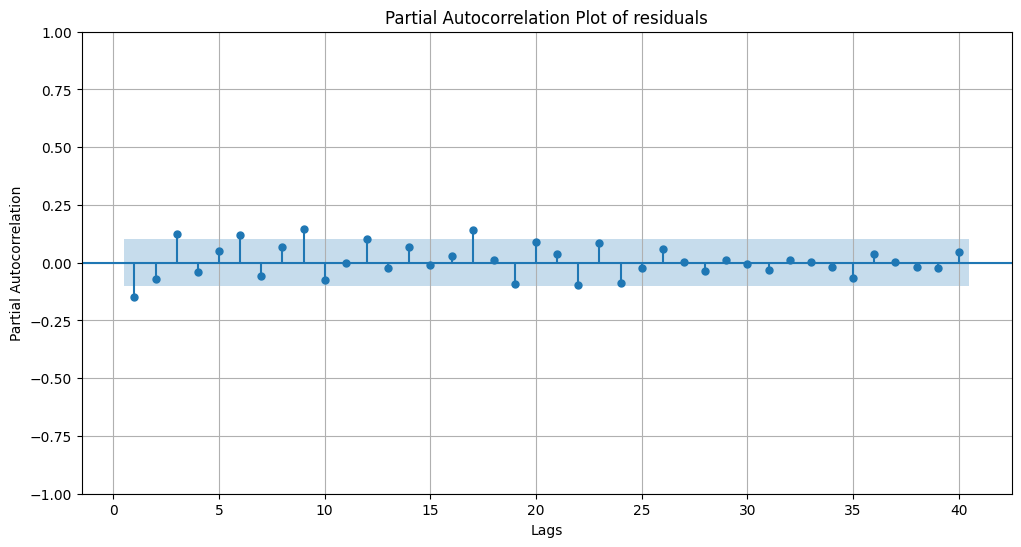

In [ ]:
# Autocorrelation plot
plt.figure(figsize=(12, 6))
plot_acf(result.resid.iloc[12:], lags=40, zero=False, ax=plt.gca())
plt.title('Autocorrelation Plot of errors / residuals')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

# Partial autocorrelation plot
plt.figure(figsize=(12, 6))
plot_pacf(result.resid.iloc[12:], zero=False, lags=40, ax=plt.gca())
plt.title('Partial Autocorrelation Plot of residuals')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.grid(True)
plt.show()

We can see in both plots an positive and negative autocorrelation with its own lag 1. If we have this scenario for this series we change the q from 0 to 1 to account (include the MA(1) term). We do this since the autocorrelation is negative and we already had included an AR(1) term.




In [ ]:
# Fit SARIMA model ARIMA(p=1,d=0,q=1) SARIMA(P=0,D=1,Q=1,#periods=12)
model = SARIMAX(igae_log, order=(1, 0, 1),
                seasonal_order=(0, 1, 1, 12),
                trend='c') # Include drift/constant term
result = model.fit()
print(result.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                            logIGAE   No. Observations:                  392
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 12)   Log Likelihood                 864.619
Date:                            Thu, 13 Nov 2025   AIC                          -1719.239
Time:                                    05:11:55   BIC                          -1699.538
Sample:                                01-01-1993   HQIC                         -1711.421
                                     - 08-01-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0033      0.001      4.632      0.000       0.002       0.005
ar.L1          0.8225      0.034   

In [ ]:
phi0 = result.params['intercept']
phi1= result.params['ar.L1']
theta1 = result.params['ma.L1']
theta2 = result.params['ma.S.L12']

print('phi0 = intercept = %f' % phi0)

print('phi1 = %f' % phi1)

print('theta1 = %f' % theta1)

print('theta2 = %f' % theta2)


phi0 = intercept = 0.003325
phi1 = 0.822456
theta1 = -0.158917
theta2 = -0.786725


We see that all coefficients of the model are statistically significant since their pvalues < 0.05. Then, we keep them in the model.

We again check whether the model residuals show autocorrelation with its own lags:

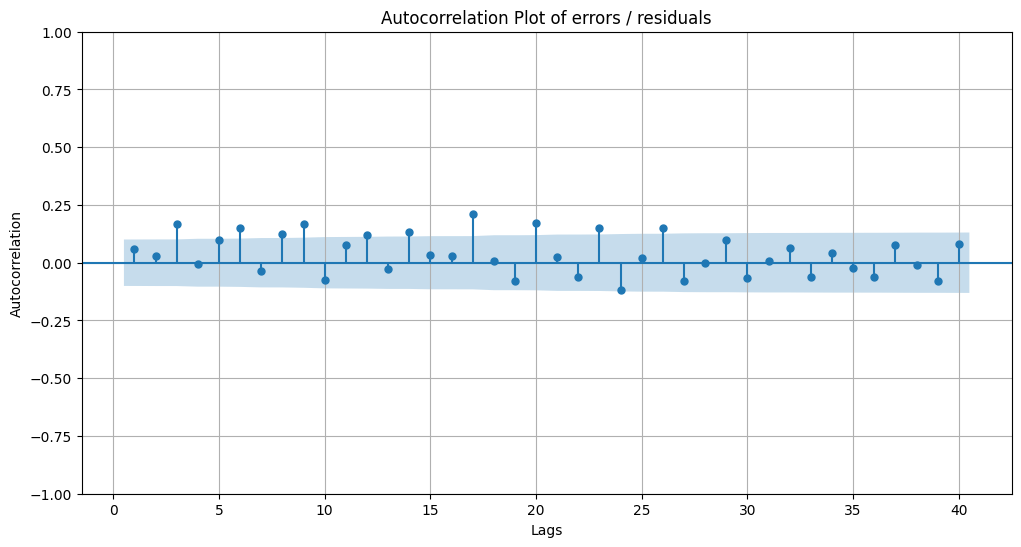

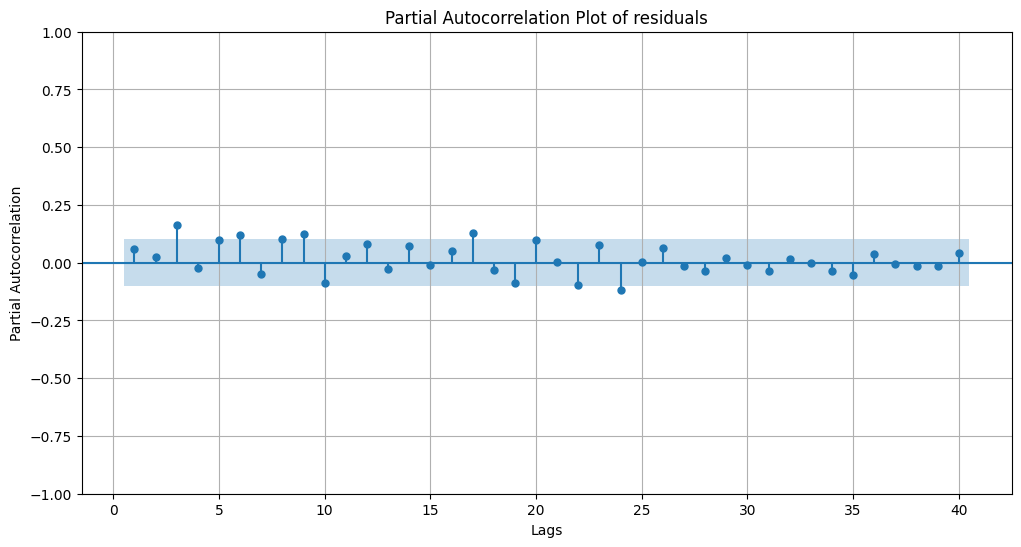

In [ ]:
# Autocorrelation plot
plt.figure(figsize=(12, 6))
plot_acf(result.resid.iloc[12:], lags=40, zero=False, ax=plt.gca())
plt.title('Autocorrelation Plot of errors / residuals')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

# Partial autocorrelation plot
plt.figure(figsize=(12, 6))
plot_pacf(result.resid.iloc[12:], zero=False, lags=40, ax=plt.gca())
plt.title('Partial Autocorrelation Plot of residuals')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.grid(True)
plt.show()

Now we see that the autocorrelations of residuals with its own past values (lags) are not significant (in general). We can see that in both the AD and PAC plots there are some barely significant autocorrelations for lags 7 and lag 10.

We could include AR or MA terms to account for these lags. But is recommend by the experience of Doctor Dorantes include just terms of lags = 1 (last month), 4 (last quarter) or 6 (last semester). And the finall model remains in:

p = 1, d = 0, q = 1

P = 0, D = 1, Q = 1

Where
Y
t
Y
t
​
  is the annual % growth of the IGAE (the seasonal difference of the log).

The sum of the
ϕ
i
ϕ
i
​
  coefficients must always be less than 1. If you find that the sum of these coefficients is bigger than 1, then you need to review the calibration process.

According to the result, we can see that the coefficients
ϕ
1
ϕ
1
​
  is positive and significant (since its p-value are <0.05). Then we can say that the IGAE annual % change is positively and significantly related with its own annual % change of 1 month ago.

Also, the
θ
1
θ
1
​
  coefficient (the MA coefficient) is negative and significant. This means that the annual % growth of the IGAE is negatively related with the error (shock) of 1 month ago. The
θ
2
θ
2
​
  coefficient (the seasonal MA coefficient) is negative and very significant. This means that the annual % growth of the IGAE is negatively related with the error (shock) of 12 months ago.



 Now run agains the final model:



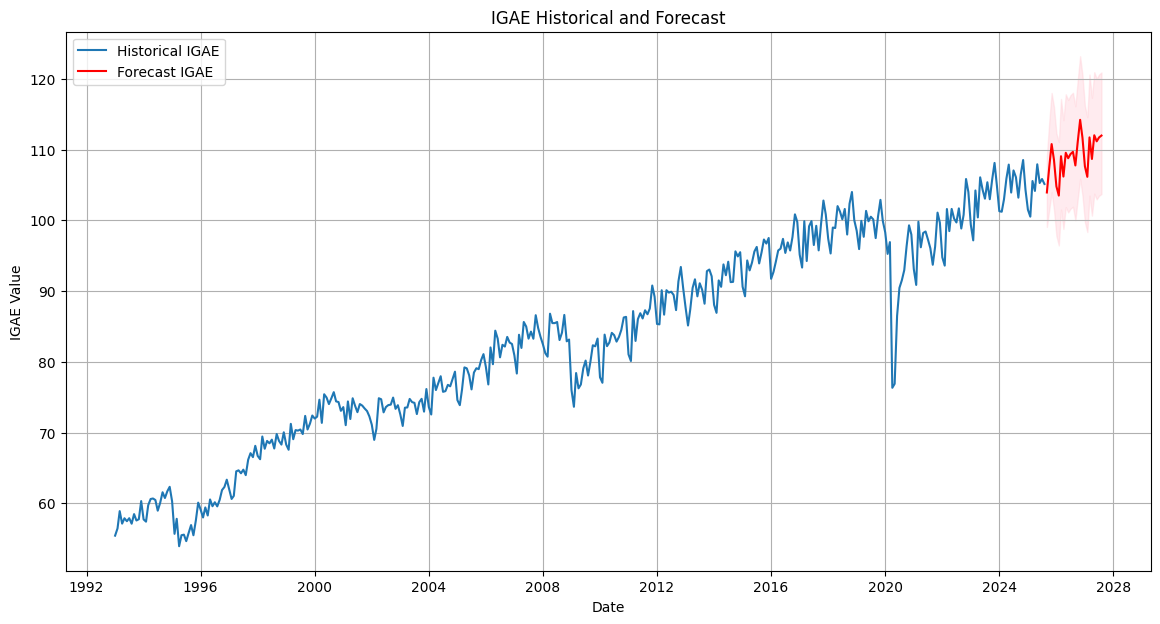

In [ ]:
# I will forecast 24 months in the future:
forecast_steps = 24
forecast_result = result.get_forecast(steps=forecast_steps)
# I get the mean forecast:
forecast_log = forecast_result.predicted_mean
# Get the 95% confidence interval of the forecast:
# alpha = 1 - confidence interval
forecast_ci = forecast_result.conf_int(alpha=0.05)

# Convert log forecast values back to original scale of IGAE
forecast_values = np.exp(forecast_log)

# Plot historical and forecast values
plt.figure(figsize=(14, 7))
plt.plot(igaedf.index, igaedf['IGAE'], label='Historical IGAE')
plt.plot(forecast_values.index, forecast_values, label='Forecast IGAE', color='red')
plt.fill_between(forecast_values.index, np.exp(forecast_ci.iloc[:, 0]), np.exp(forecast_ci.iloc[:, 1]), color='pink', alpha=0.3) # Plot confidence interval

plt.title('IGAE Historical and Forecast')
plt.xlabel('Date')
plt.ylabel('IGAE Value')
plt.grid(True)
plt.legend()
plt.show()

### Interpretation of the model:

AR(1) coefficient or
ϕ
1
ϕ
1
​
  = +0.93. This means that the GDP annual % change is positively and significantly (its pvalue<0.05) autocorrelated in 93% with its own annual % change of the previous quarter. Then, if the previous quarter the GDP annual % change was positive, it is very likely that this quarter will also be positive; also, if the previous quarter the annual %change was negative, then it is very lilkely that this quarter will also be negative.

MA(1) coefficient or
θ
1
θ
1
​
  = -0.25. This means that the GDP annual % change is negatively and significantly related with the errors (shocks) of the previous quarter.

Seasonal MA(1) coefficient or
θ
2
θ
2
​
  = -0.83. This means that the GDP annual % change is negatively and significantly related with the errors (shocks) of the previous year (4 quarters ago) in about -83%.

# Challenge 1

Download the Real Gross Domestic Product for Mexico from the FRED online site (US Federal Reserve Bank). Use the ticker NGDPRNSAXDCMXQ. You have to:

1. Calibrate an ARIMA-SARIMA to forecast the Mexico GDP for the the rest of 2025 and all quarters of 2026.

2. You have to explain your calibration steps, and

3. Interpret the final model.

In [ ]:
# prompt: Download the series NGDPRNSAXDCMXQ from the FRED site since 1993, and using pandas_reader
# Install the pandas_datareader:
#!pip install pandas_datareader

import pandas_datareader as pdr
# This part is already done in the preceding code.
series_id = "NGDPRNSAXDCMXQ"
mxgdpdf = pdr.get_data_fred(series_id,start='1993-01-01')
mxgdpdf.columns=['MXGDP']
print(mxgdpdf.head())

                MXGDP
DATE                 
1993-01-01  3439763.5
1993-04-01  3472286.3
1993-07-01  3465719.7
1993-10-01  3519338.2
1994-01-01  3525020.1


According to the FRED, this series has the Mexico Real GDP (Not Seasonally adjusted) in $Millions of Mexican Pesos.

### Plot of real Mexico GDP over time:

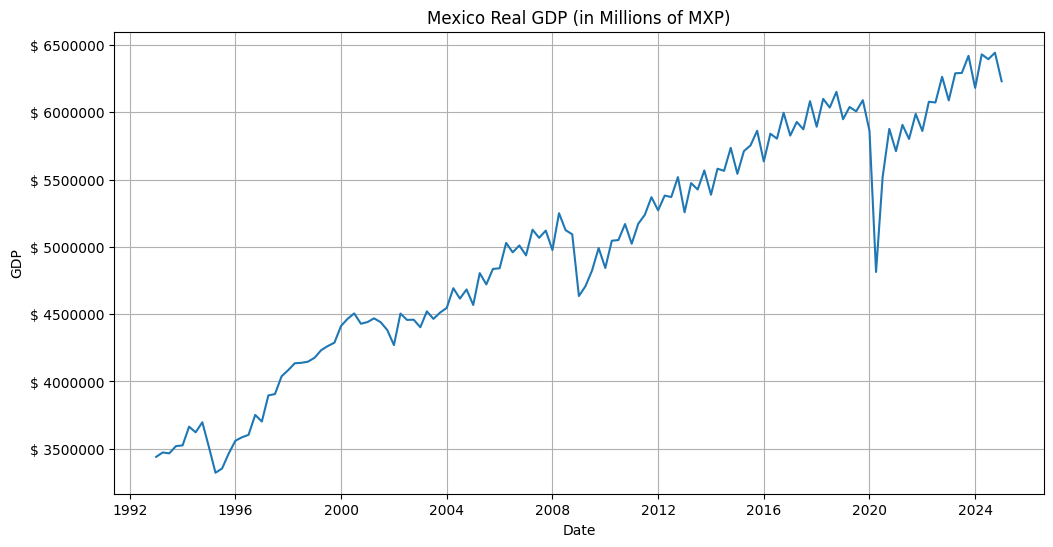

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

plt.figure(figsize=(12, 6))
plt.plot(mxgdpdf.index, mxgdpdf['MXGDP'])
plt.title('Mexico Real GDP (in Millions of MXP)')
plt.xlabel('Date')
plt.ylabel('GDP')
# Format the y-axis to show in currency format
formatter = mticker.FormatStrFormatter('$ %1.0f')
plt.gca().yaxis.set_major_formatter(formatter)

plt.grid(True)
plt.show()

### 1. Apply the log to the endogenous variable

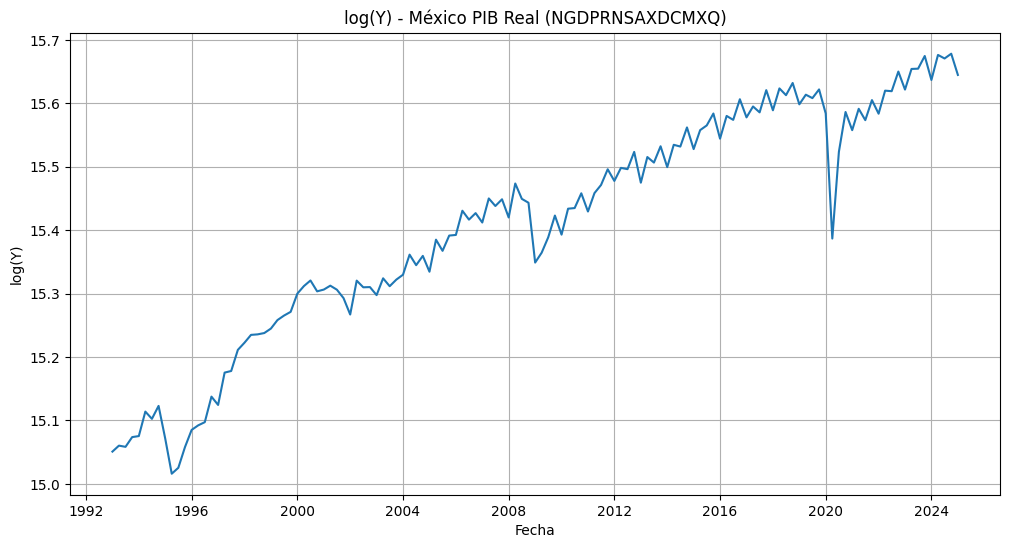

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Asumimos que mxgdpdf ya existe y tiene la columna 'MXGDP' como tu Y
mxgdpdf = mxgdpdf.copy()
mxgdpdf['logY'] = np.log(mxgdpdf['MXGDP'])

# Graficar log(Y)
plt.figure(figsize=(12, 6))
plt.plot(mxgdpdf.index, mxgdpdf['logY'])
plt.title('log(Y) - México PIB Real (NGDPRNSAXDCMXQ)')
plt.xlabel('Fecha')
plt.ylabel('log(Y)')
plt.grid(True)
plt.show()


Now we apply the log to the endogenous variable and we see a reduced scale, but we have almost for sure that this series is not stationary, so then...

### Get the difference in covid crisis

In [ ]:
import pandas as pd
import numpy as np

# Fechas de referencia
start_covid = pd.to_datetime('2020-01-01')
end_covid   = mxgdpdf.index.max()  # último dato disponible

# Aseguramos que el índice esté ordenado
mxgdpdf = mxgdpdf.sort_index()

# Obtener los valores del log en las fechas más cercanas
log_start = mxgdpdf.loc[mxgdpdf.index.asof(start_covid), 'logY']
log_end = mxgdpdf.loc[mxgdpdf.index.asof(end_covid), 'logY']

# Diferencia total
diff_log = log_end - log_start

print(f"Inicio COVID (≈ {start_covid.date()}): log(Y) = {log_start:.4f}")
print(f"Final serie (≈ {end_covid.date()}): log(Y) = {log_end:.4f}")
print(f"Diferencia total en log(Y): {diff_log:.4f}")
print(f"Equivale aproximadamente a un cambio de {np.exp(diff_log) - 1:.2%} en el nivel del PIB real.")


Inicio COVID (≈ 2020-01-01): log(Y) = 15.5841
Final serie (≈ 2025-01-01): log(Y) = 15.6449
Diferencia total en log(Y): 0.0608
Equivale aproximadamente a un cambio de 6.27% en el nivel del PIB real.


Is for sure that we have a non stationary series due the unpredectible trend and the variation in the mean of the series, so now we will:

### 2. Apply the seasonal log difference to the series

With this, the result is expected to transform the series from stationary to non-stationary.

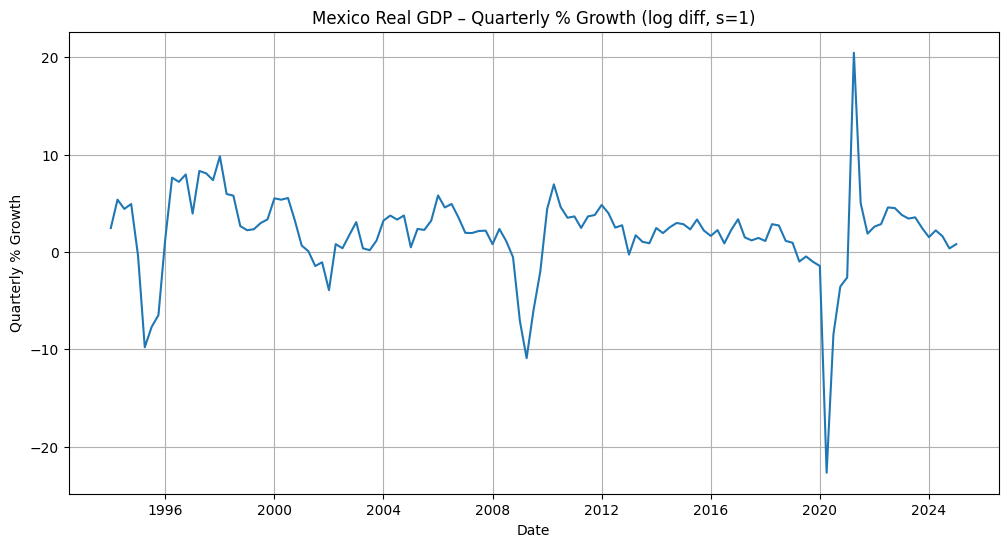

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Diferencia logarítmica con rezago 1 (primer diferencia)
mxgdpdf['growth'] = mxgdpdf['logY'] - mxgdpdf['logY'].shift(4)
# También podrías hacer: mxgdpdf['growth2'] = mxgdpdf['logY'].diff(1)

# Graficar la serie de crecimiento trimestral
plt.figure(figsize=(12, 6))
plt.plot(mxgdpdf.index, 100 * mxgdpdf['growth'])
plt.title('Mexico Real GDP – Quarterly % Growth (log diff, s=1)')
plt.xlabel('Date')
plt.ylabel('Quarterly % Growth')
plt.grid(True)
plt.show()


It looks like a more predictible and constand plot, but lets confirm if is stationary with:

### 3. Appling a Dicky-Fuller test.

In [ ]:
from statsmodels.tsa.stattools import adfuller

dftest = adfuller(mxgdpdf['growth'].dropna())

print('ADF Statistic: %f' % dftest[0])
print('p-value: %f' % dftest[1])
print('Critical Values:')
for key, value in dftest[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.527930
p-value: 0.007298
Critical Values:
	1%: -3.488
	5%: -2.887
	10%: -2.580


The results tell us that the original series is non stationary as we thought and we can reject the hipohtesis so this new series with the first difference, we can treat it as a stationary and is suitable for a ARIMA/SARIMA model. This due a p-value less than 0.05

### 4. AC and PAC

Now I will apply a Autocorrelogram and Partial Autocorrelogram plot, wee need it later to calibrate the model.

<Figure size 1200x600 with 0 Axes>

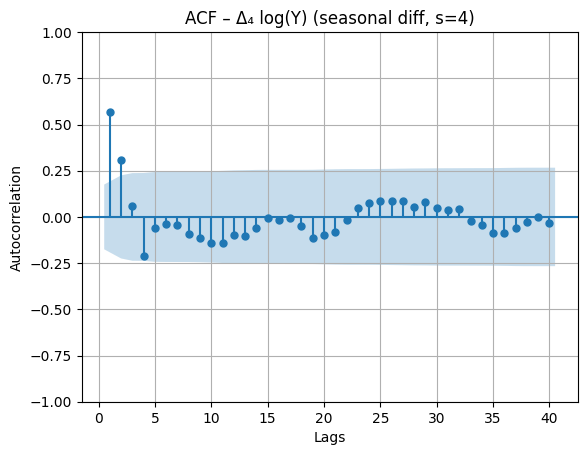

<Figure size 1200x600 with 0 Axes>

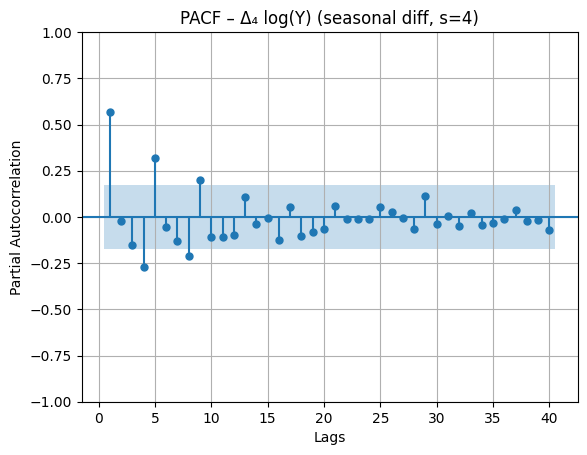

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import pandas as pd

# Serie estacionaria: diferencia estacional del log (s=4)
mxgdpdf = mxgdpdf.copy()
mxgdpdf['logY_seasdiff'] = mxgdpdf['logY'].diff(4)

y = mxgdpdf['logY_seasdiff'].dropna()

# ACF
plt.figure(figsize=(12, 6))
plot_acf(y, lags=40, zero=False)
plt.title('ACF – Δ₄ log(Y) (seasonal diff, s=4)')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

# PACF
plt.figure(figsize=(12, 6))
plot_pacf(y, lags=40, zero=False)
plt.title('PACF – Δ₄ log(Y) (seasonal diff, s=4)')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.grid(True)
plt.show()


### Calibrating the ARIMA-SARIMA model

Now we will calibrate the model, we have for sure the value of d and D, this due the transformation form non-stationary to stationary. So...

d=0

D=1

So we will see if we have a AR or MA signature.

### 5. Check the AR or MA signature

We can confirm that this series has a AR signature for 2 reasons:

- The AC plot decay gradually
- The PAC decay suddenly

And the initial values are:

p = 1 -> This due the first autocorrelated in PAC are just 1 continous.

q = 0 -> Due AR signature.

d = 0

D = 1

d and D due the transformation to a stationary series

### Calculate P Q

Now I will calculate P and Q for this:

### 6. Run a ARIMA-SARIMA model with P Q setted to 0

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

gdp_log = mxgdpdf['logY'].dropna()

# Fit SARIMA model ARIMA(p=1,d=0,q=0) SARIMA(P=0,D=1,Q=0,#periods=4)
model = SARIMAX(gdp_log,
                order=(1, 0, 0),
                seasonal_order=(0, 1, 0, 4),
                trend='c')
result = model.fit()
print(result.summary())


                                     SARIMAX Results                                     
Dep. Variable:                              logY   No. Observations:                  129
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 4)   Log Likelihood                 237.829
Date:                           Thu, 13 Nov 2025   AIC                           -469.658
Time:                                   05:11:56   BIC                           -461.173
Sample:                               01-01-1993   HQIC                          -466.211
                                    - 01-01-2025                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0084      0.003      2.572      0.010       0.002       0.015
ar.L1          0.5634      0.063      9.003

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


In [ ]:
phi0 = result.params['intercept']
phi1= result.params['ar.L1']

print('phi0 = intercept = %f' % phi0)
print('phi1 = %f' % phi1)

phi0 = intercept = 0.008443
phi1 = 0.563442


We can se that both are possitive significative since their p-value is less than 0.005.

### 7. Check residuals have white noise

Check if have white noise with the AC PAC plot of the residuals

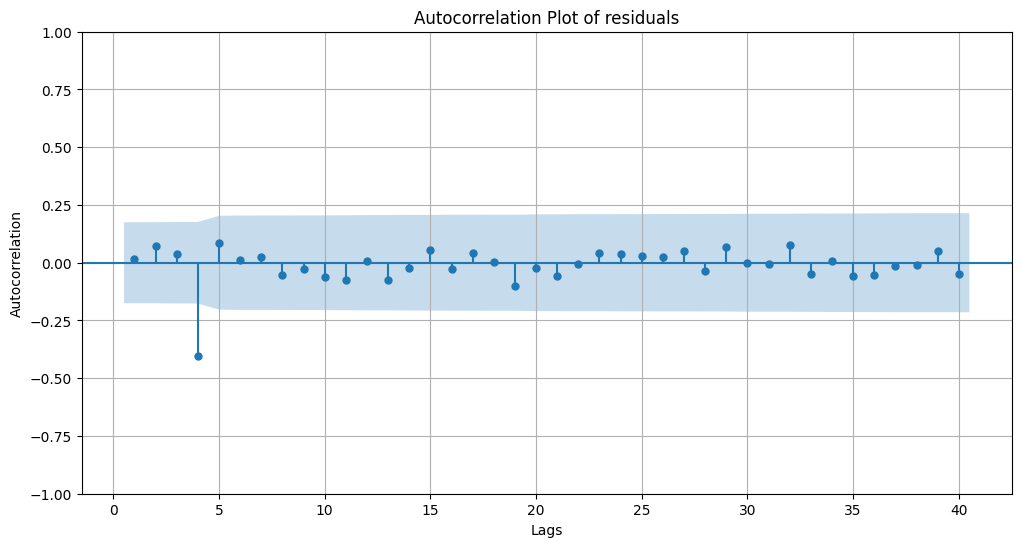

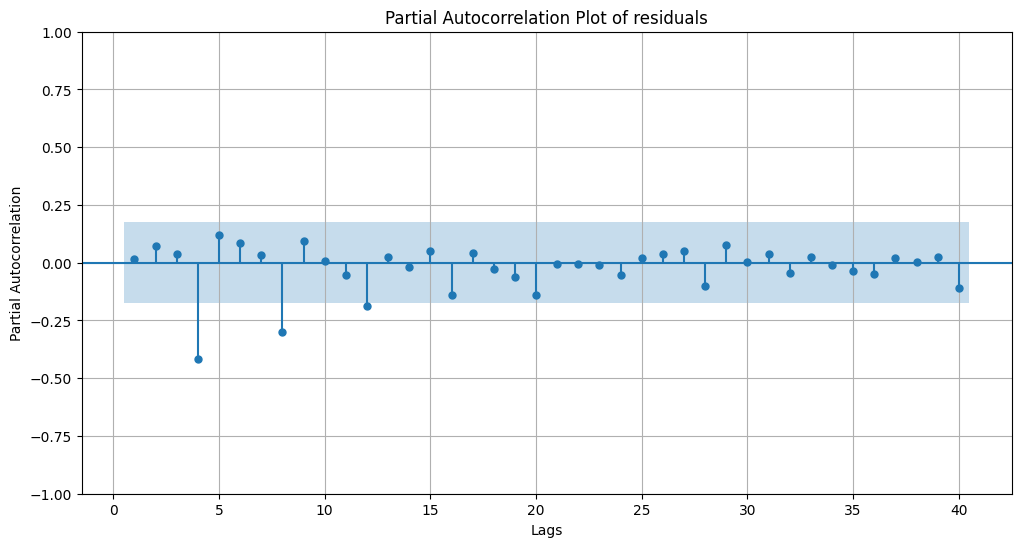

In [ ]:
# Autocorrelation plot
plt.figure(figsize=(12, 6))
plot_acf(result.resid.iloc[4:], lags=40, zero=False, ax=plt.gca())
plt.title('Autocorrelation Plot of residuals')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

# Partial autocorrelation plot
plt.figure(figsize=(12, 6))
plot_pacf(result.resid.iloc[4:], zero=False, lags=40, ax=plt.gca())
plt.title('Partial Autocorrelation Plot of residuals')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.grid(True)
plt.show()

We still see negativa autocorrelation just in first and second seasons so we will apply the thum rule:

selecting a seasonal MA term and NO AR terms. In other words, we start setting the values for P and Q as:

P = 0

Q = 1

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

gdp_log = mxgdpdf['logY'].dropna()

# Fit SARIMA model ARIMA(p=1,d=0,q=0) SARIMA(P=0,D=1,Q=0,#periods=4)
model = SARIMAX(gdp_log,
                order=(1, 0, 0),
                seasonal_order=(0, 1, 1, 4),
                trend='c')
result = model.fit()
print(result.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                                logY   No. Observations:                  129
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 4)   Log Likelihood                 262.560
Date:                             Thu, 13 Nov 2025   AIC                           -517.120
Time:                                     05:11:57   BIC                           -505.807
Sample:                                 01-01-1993   HQIC                          -512.524
                                      - 01-01-2025                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0039      0.001      5.041      0.000       0.002       0.005
ar.L1          0.7935      

In [ ]:
phi0 = result.params['intercept']
phi1= result.params['ar.L1']
theta1 = result.params['ma.S.L4']

print('phi0 = intercept = %f' % phi0)
print('phi1 = %f' % phi1)
print('theta1 = %f' % theta1)


phi0 = intercept = 0.003886
phi1 = 0.793549
theta1 = -0.837288


The seasonal MA term was -0.8372, and was statistically significant since its p-value is much less than 0.05. Then we keep it in the model.

### 8. Check again if this second model has a significand autocorrelation with its own values

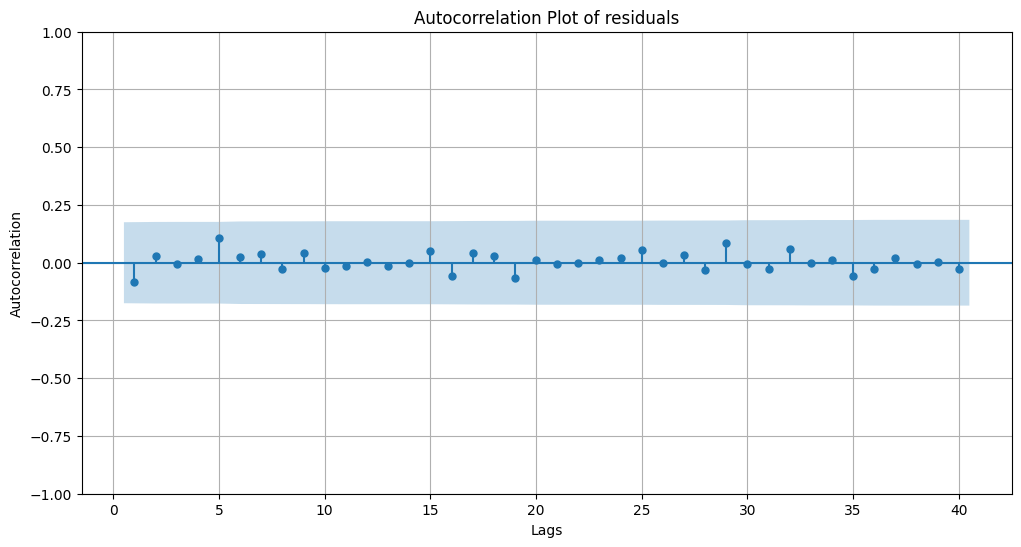

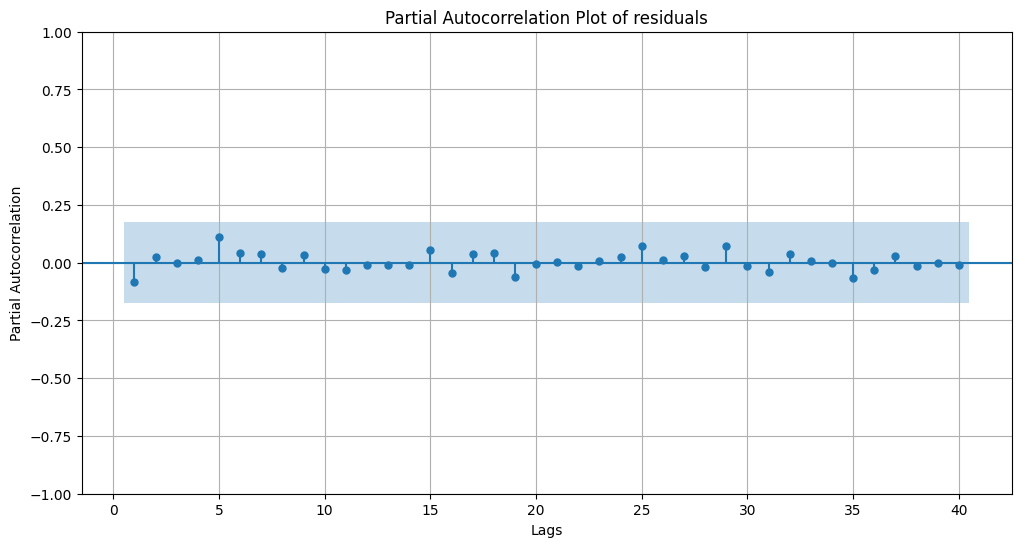

In [ ]:
# Autocorrelation plot
plt.figure(figsize=(12, 6))
plot_acf(result.resid.iloc[4:], lags=40, zero=False, ax=plt.gca())
plt.title('Autocorrelation Plot of residuals')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

# Partial autocorrelation plot
plt.figure(figsize=(12, 6))
plot_pacf(result.resid.iloc[4:], zero=False, lags=40, ax=plt.gca())
plt.title('Partial Autocorrelation Plot of residuals')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.grid(True)
plt.show()

Now any of its lags are autocorrelated, so our model is already calibrated.

p = 1

d = 0

q = 0

P = 0

D = 1

Q = 1

### 9. Prediction

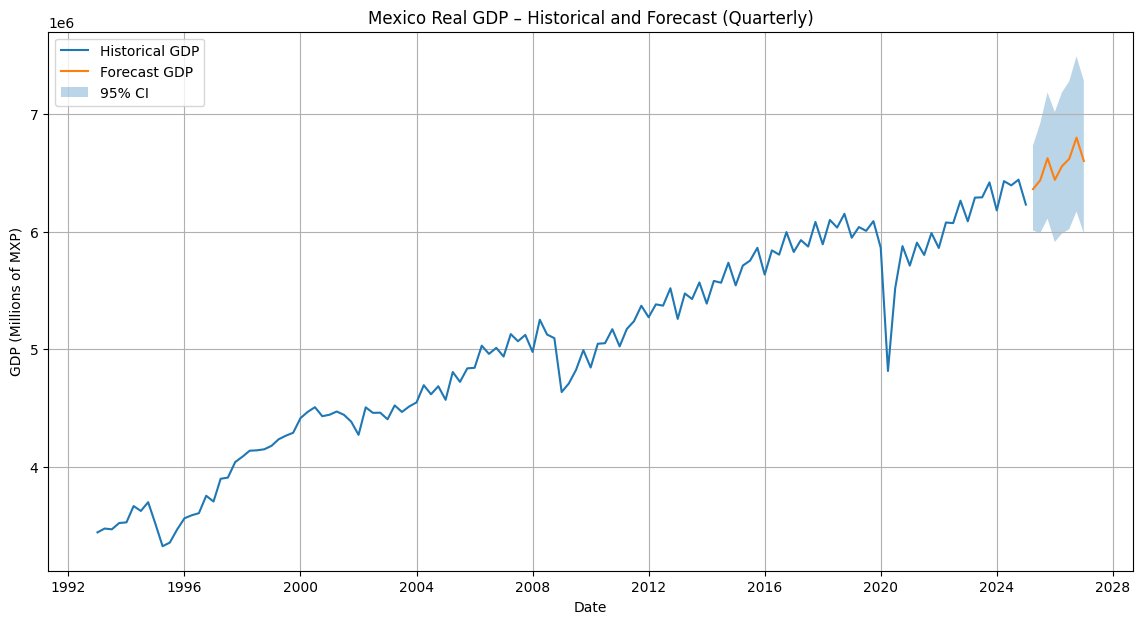

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# === Forecast (8 quarters ≈ 24 months) ===
forecast_steps = 8
forecast_result = result.get_forecast(steps=forecast_steps)

# Predicción en log (mismo nivel que gdp_log)
forecast_log = forecast_result.predicted_mean
forecast_ci = forecast_result.conf_int(alpha=0.05)

# Volver a escala original (niveles de PIB)
forecast_values = np.exp(forecast_log)
ci_lower = np.exp(forecast_ci.iloc[:, 0])
ci_upper = np.exp(forecast_ci.iloc[:, 1])

# === Plot histórico y pronóstico ===
plt.figure(figsize=(14, 7))
plt.plot(mxgdpdf.index, mxgdpdf['MXGDP'], label='Historical GDP')
plt.plot(forecast_values.index, forecast_values, label='Forecast GDP')
plt.fill_between(forecast_values.index, ci_lower, ci_upper, alpha=0.3, label='95% CI')

plt.title('Mexico Real GDP – Historical and Forecast (Quarterly)')
plt.xlabel('Date')
plt.ylabel('GDP (Millions of MXP)')
plt.grid(True)
plt.legend()
plt.show()


### 10. Interpretation

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

gdp_log = mxgdpdf['logY'].dropna()

# Fit SARIMA model ARIMA(p=1,d=0,q=0) SARIMA(P=0,D=1,Q=0,#periods=4)
model = SARIMAX(gdp_log,
                order=(1, 0, 0),
                seasonal_order=(0, 1, 1, 4),
                trend='c')
result = model.fit()
print(result.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                                logY   No. Observations:                  129
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 4)   Log Likelihood                 262.560
Date:                             Thu, 13 Nov 2025   AIC                           -517.120
Time:                                     05:11:59   BIC                           -505.807
Sample:                                 01-01-1993   HQIC                          -512.524
                                      - 01-01-2025                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0039      0.001      5.041      0.000       0.002       0.005
ar.L1          0.7935      

- Intercept: We have a 0.39% of positive growth each quarter, and annual 1.56% in my opinion a very small growth compared to other seasons or years.

- AR(1): The growth of the last quarter have a heavy impact in the current.

- MA Seasonal L4: The growth of ther last year is reversed and we get the effect mean-reversion anual where if the last year was a positive effect now a negative.

Overall the numbers are there and everything idicates that we will be growing up, but this is a basic prediction and we are not considering a lot of exogenous variables. I hope those variables and very unpridectible as the internal and external politics do not have a negative impact in our economy.

# Challenge 2

Do the same as above, but now for the US Real GDP:

1. Download the Real Gross Domestic Product for the US from the FRED online site (US Federal Reserve Bank). Use the ticker NGDPRNSAXDCMXQ. You have to:

2. Calibrate an ARIMA-SARIMA to forecast the US GDP for the the rest of 2025 and all quarters of 2026.

3. Using your previous Mexico SARIMA model, use the US GDP annual % growth as an explanatory variable (exogenous variable).

4. Interpret the final model.

In [ ]:

import pandas_datareader as pdr
# This part is already done in the preceding code.
series_id = "NGDPRNSAXDCUSQ"
usgdpdf = pdr.get_data_fred(series_id,start='1993-01-01')
usgdpdf.columns=['USGDP']
print(usgdpdf.head())

              USGDP
DATE               
2002-01-01  3501118
2002-04-01  3608496
2002-07-01  3650253
2002-10-01  3712845
2003-01-01  3582767


### Plot the real US GDP over time.






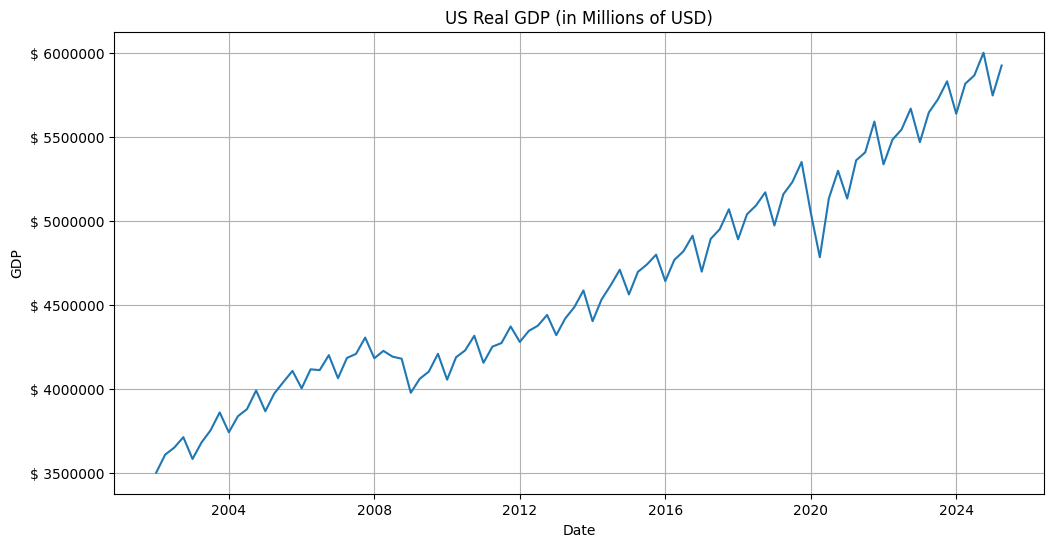

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

plt.figure(figsize=(12, 6))
plt.plot(usgdpdf.index, usgdpdf['USGDP'])
plt.title('US Real GDP (in Millions of USD)')
plt.xlabel('Date')
plt.ylabel('GDP')
# Format the y-axis to show in currency format
formatter = mticker.FormatStrFormatter('$ %1.0f')
plt.gca().yaxis.set_major_formatter(formatter)

plt.grid(True)
plt.show()

### 1. Apply the log to the endogenous variable

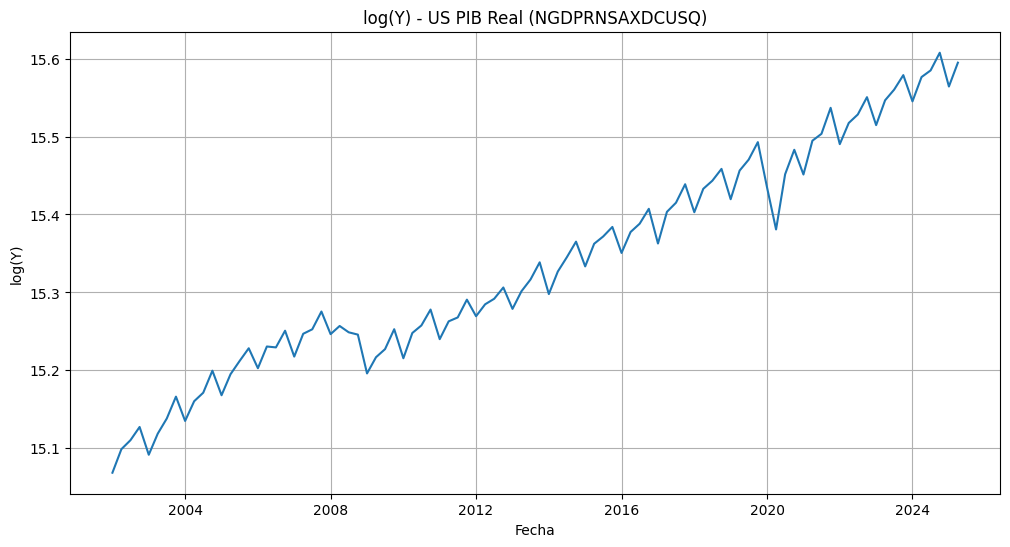

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Asumimos que mxgdpdf ya existe y tiene la columna 'MXGDP' como tu Y
usgdpdf = usgdpdf.copy()
usgdpdf['logY'] = np.log(usgdpdf['USGDP'])

# Graficar log(Y)
plt.figure(figsize=(12, 6))
plt.plot(usgdpdf.index, usgdpdf['logY'])
plt.title('log(Y) - US PIB Real (NGDPRNSAXDCUSQ)')
plt.xlabel('Fecha')
plt.ylabel('log(Y)')
plt.grid(True)
plt.show()

Now we reduced the scale. Just to confirm, we will apply the seasonal first difrence in order to know if its an stationary or not series.

### 2. Apply the seasonal log difference to the series


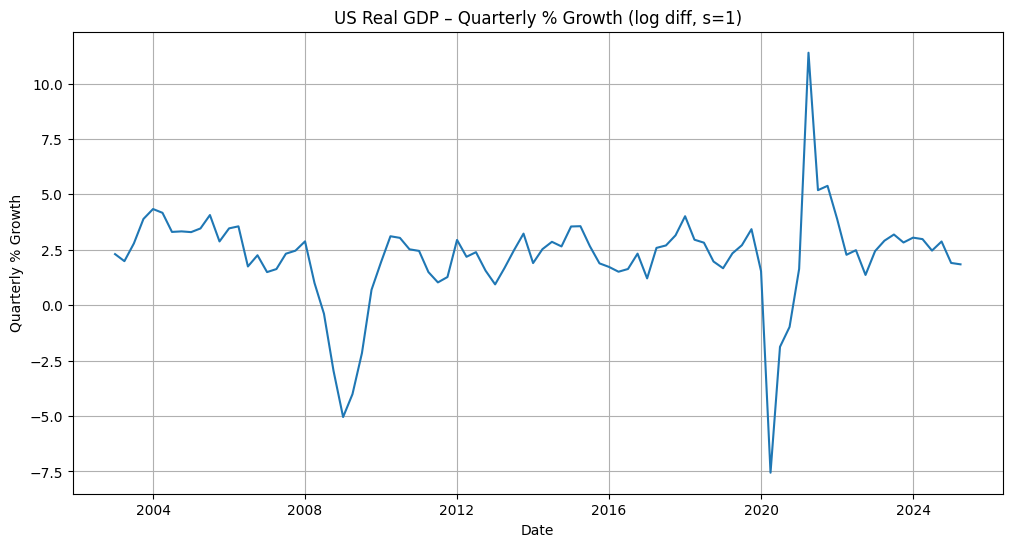

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Diferencia logarítmica con rezago 1 (primer diferencia)
usgdpdf['growth'] = usgdpdf['logY'] - usgdpdf['logY'].shift(4)

# Graficar la serie de crecimiento trimestral
plt.figure(figsize=(12, 6))
plt.plot(usgdpdf.index, 100 * usgdpdf['growth'])
plt.title('US Real GDP – Quarterly % Growth (log diff, s=1)')
plt.xlabel('Date')
plt.ylabel('Quarterly % Growth')
plt.grid(True)
plt.show()


Now this looks like more as an stationary series but lets confirm:

### 3. Appling a Dicky-Fuller test.

In [ ]:
from statsmodels.tsa.stattools import adfuller

dftest = adfuller(usgdpdf['growth'].dropna())

print('ADF Statistic: %f' % dftest[0])
print('p-value: %f' % dftest[1])
print('Critical Values:')
for key, value in dftest[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.203249
p-value: 0.019797
Critical Values:
	1%: -3.510
	5%: -2.896
	10%: -2.585


It is confirmed that the original series is not stationary just as the most common statistics series, and this with the seasonal difference we can treat this series as stationary, lets do the next steps:

### 4. AC and PAC

Now I will apply a Autocorrelogram and Partial Autocorrelogram plot, wee need it later to calibrate the model.

<Figure size 1200x600 with 0 Axes>

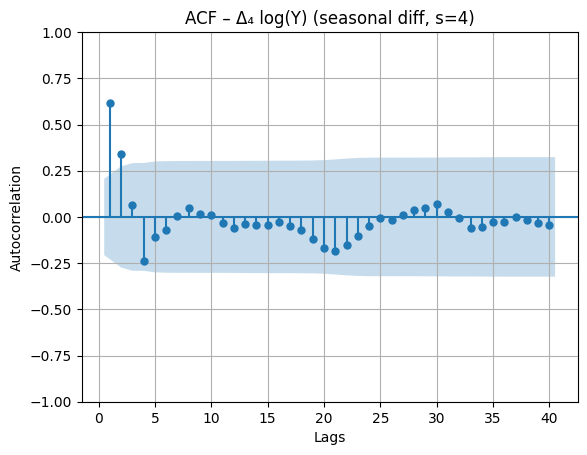

<Figure size 1200x600 with 0 Axes>

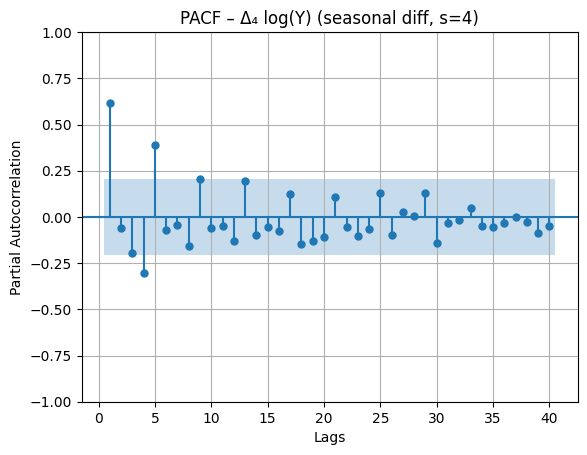

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import pandas as pd

# Serie estacionaria: diferencia estacional del log (s=4)
usgdpdf = usgdpdf.copy()
usgdpdf['logY_seasdiff'] = usgdpdf['logY'].diff(4)

y = usgdpdf['logY_seasdiff'].dropna()

# ACF
plt.figure(figsize=(12, 6))
plot_acf(y, lags=40, zero=False)
plt.title('ACF – Δ₄ log(Y) (seasonal diff, s=4)')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

# PACF
plt.figure(figsize=(12, 6))
plot_pacf(y, lags=40, zero=False)
plt.title('PACF – Δ₄ log(Y) (seasonal diff, s=4)')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.grid(True)
plt.show()


### Calibrating the ARIMA-SARIMA model

Now we will calibrate the model, we have for sure the value of d and D, this due the transformation form non-stationary to stationary. So...

d=0

D=1

So we will see if we have a AR or MA signature.



### Check AR or MA signature

We can confirm that we have an AR signature, this due:

- The AC plot the first autocorrelated lags are decreasing gradually or drops over time.
- PAC suddenly drop in the next lag.

And the initial values are:

p = 1 -> This due the first autocorrelated in PAC are just 1 continous.

q = 0 -> Due AR signature.

d = 0

D = 1

d and D because we transform our original series to no stationary.

Lets go ahead with next steps

### Calibrating the ARIMA-SARIMA model

Now we will calibrate the model and decide if we add AR terms or MA terms:
p,d,q and P,D,Q.


### Lets run a model with the setted variables p,q and P, Q setted to 0.

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

gdp_log = usgdpdf['logY'].dropna()

# Fit SARIMA model ARIMA(p=1,d=0,q=0) SARIMA(P=0,D=1,Q=0,#periods=4)
model = SARIMAX(gdp_log,
                order=(1, 0, 0),
                seasonal_order=(0, 1, 0, 4),
                trend='c')
result = model.fit()
print(result.summary())


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:                              logY   No. Observations:                   94
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 4)   Log Likelihood                 237.567
Date:                           Thu, 13 Nov 2025   AIC                           -469.134
Time:                                   05:12:00   BIC                           -461.634
Sample:                               01-01-2002   HQIC                          -466.109
                                    - 04-01-2025                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0084      0.002      4.055      0.000       0.004       0.013
ar.L1          0.6090      0.074      8.221

In [ ]:
phi0 = result.params['intercept']
phi1= result.params['ar.L1']

print('phi0 = intercept = %f' % phi0)
print('phi1 = %f' % phi1)

phi0 = intercept = 0.008440
phi1 = 0.608961


We can see both variables are positive autocorrelated since the p-value is less than 0.05, so then...

### Check residuals have white noise

Check if have white noise with the AC PAC plot of the residuals

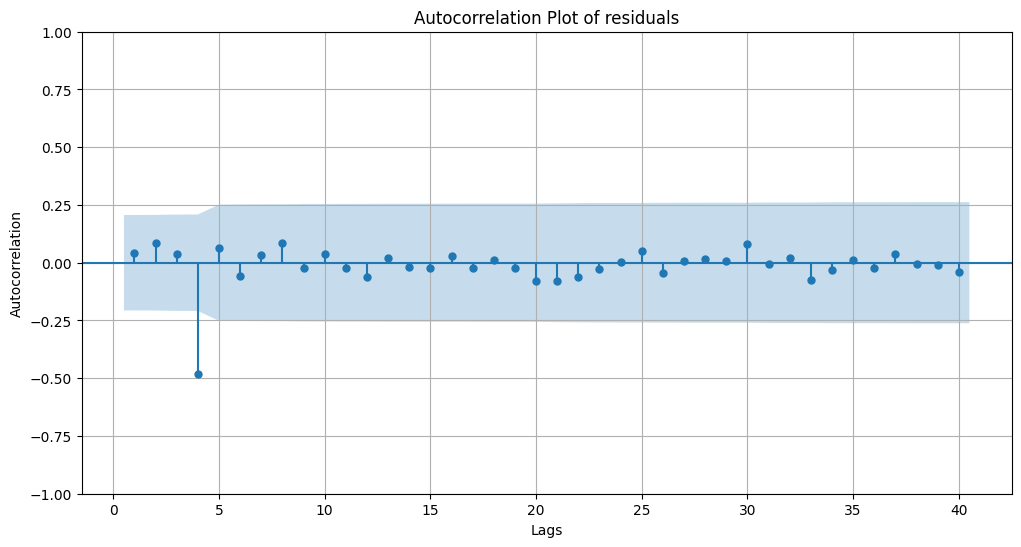

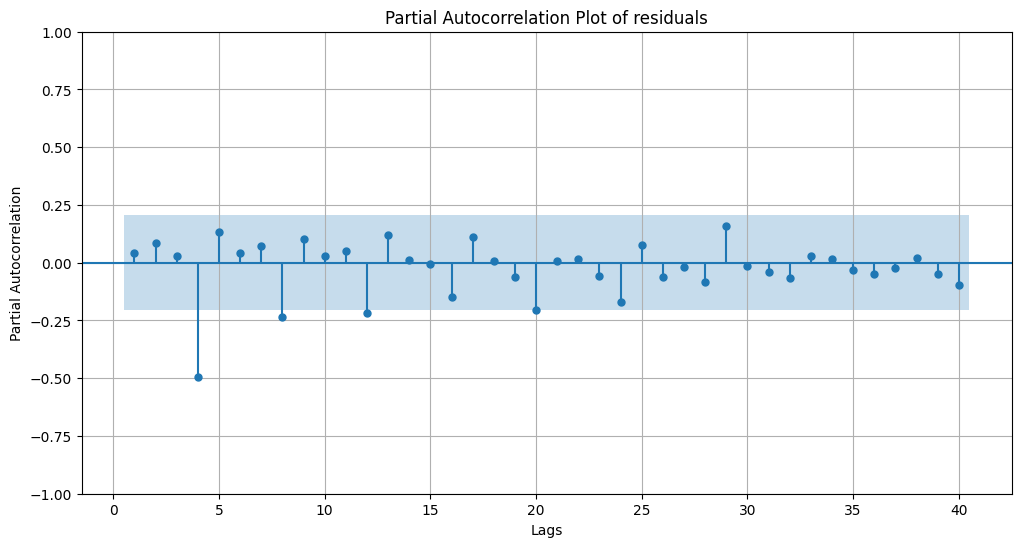

In [ ]:
# Autocorrelation plot
plt.figure(figsize=(12, 6))
plot_acf(result.resid.iloc[4:], lags=40, zero=False, ax=plt.gca())
plt.title('Autocorrelation Plot of residuals')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

# Partial autocorrelation plot
plt.figure(figsize=(12, 6))
plot_pacf(result.resid.iloc[4:], zero=False, lags=40, ax=plt.gca())
plt.title('Partial Autocorrelation Plot of residuals')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.grid(True)
plt.show()

We still see negativa autocorrelation just in first and second seasons so we will apply the thum rule:

selecting a seasonal MA term and NO AR terms. In other words, we start setting the values for P and Q as:

P = 0

Q = 1

Lets run again now the model with P and Q setted

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

gdp_log = usgdpdf['logY'].dropna()

# Fit SARIMA model ARIMA(p=1,d=0,q=0) SARIMA(P=0,D=1,Q=0,#periods=4)
model = SARIMAX(gdp_log,
                order=(1, 0, 0),
                seasonal_order=(0, 1, 1, 4),
                trend='c')
result = model.fit()
print(result.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                                logY   No. Observations:                   94
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 4)   Log Likelihood                 261.824
Date:                             Thu, 13 Nov 2025   AIC                           -515.648
Time:                                     05:12:01   BIC                           -505.649
Sample:                                 01-01-2002   HQIC                          -511.616
                                      - 04-01-2025                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0028      0.001      2.437      0.015       0.001       0.005
ar.L1          0.8660      

In [ ]:
phi0 = result.params['intercept']
phi1= result.params['ar.L1']
theta1 = result.params['ma.S.L4']

print('phi0 = intercept = %f' % phi0)
print('phi1 = %f' % phi1)
print('theta1 = %f' % theta1)

phi0 = intercept = 0.002752
phi1 = 0.866035
theta1 = -0.999501


The seasonal MA term was -0.999, and was statistically significant since its p-value is much less than 0.05. Then we keep it in the model.

Lets plot again AC PAC in order to see if we are missing something to be explained or we have alreday calibrated or model.

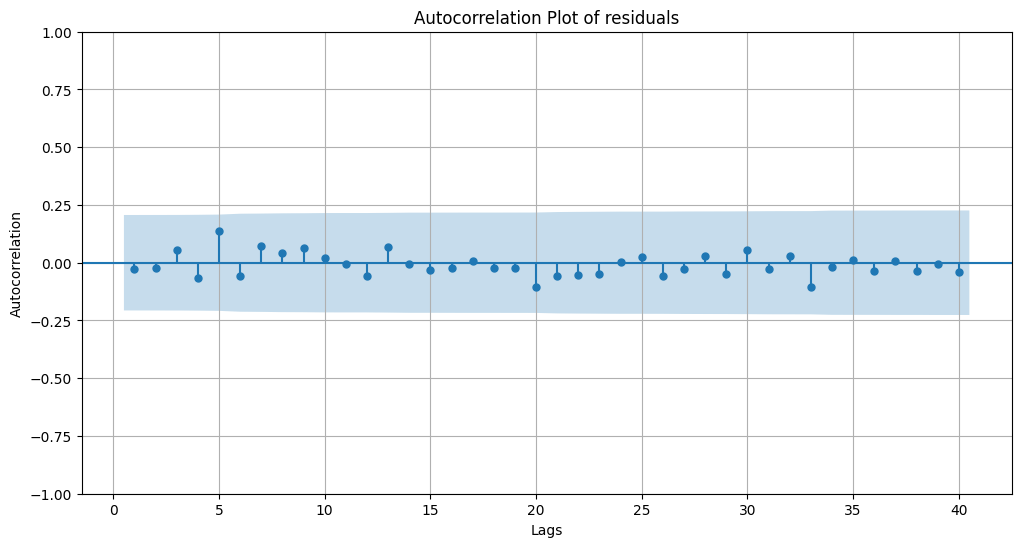

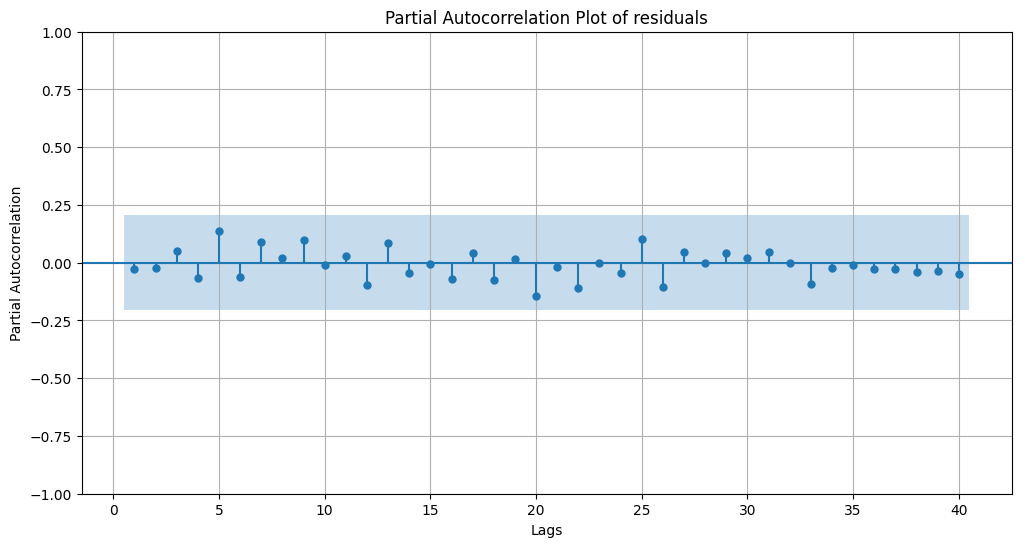

In [ ]:
# Autocorrelation plot
plt.figure(figsize=(12, 6))
plot_acf(result.resid.iloc[4:], lags=40, zero=False, ax=plt.gca())
plt.title('Autocorrelation Plot of residuals')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

# Partial autocorrelation plot
plt.figure(figsize=(12, 6))
plot_pacf(result.resid.iloc[4:], zero=False, lags=40, ax=plt.gca())
plt.title('Partial Autocorrelation Plot of residuals')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.grid(True)
plt.show()

Just as the MXGDP we already have a calibrated model, it makes sense because are the same type of stat/measure.

Now any of its lags are autocorrelated, so our model is already calibrated.

p = 1

d = 0

q = 0

P = 0

D = 1

Q = 1

### Prediction

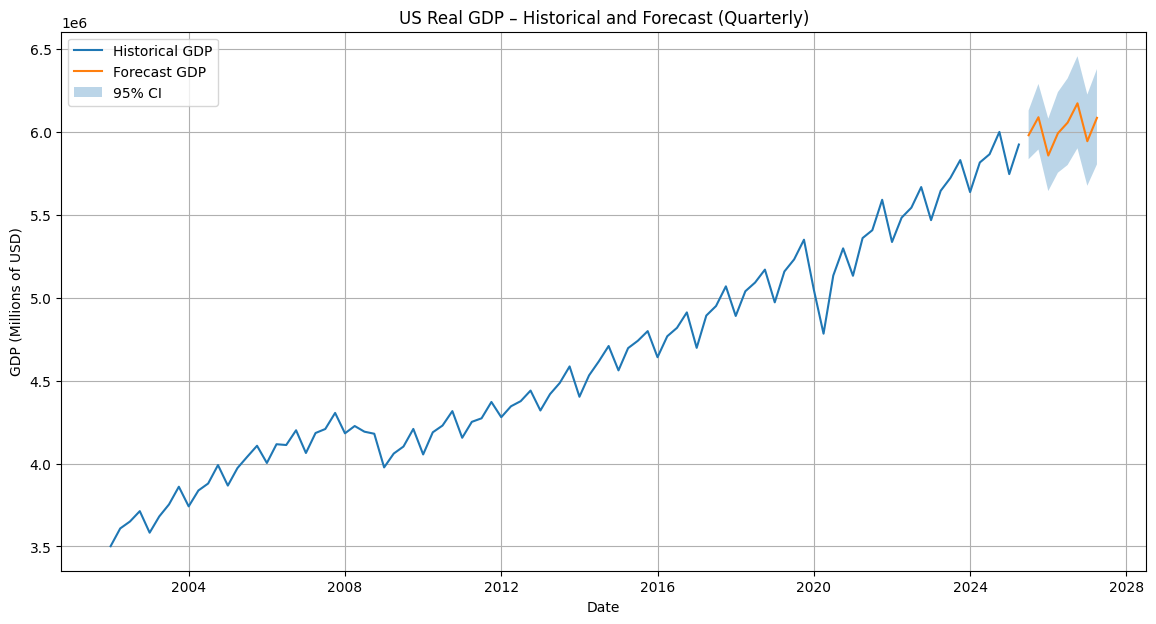

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# === Forecast (8 quarters ≈ 24 months) ===
forecast_steps = 8
forecast_result = result.get_forecast(steps=forecast_steps)

# Predicción en log (mismo nivel que gdp_log)
forecast_log = forecast_result.predicted_mean
forecast_ci = forecast_result.conf_int(alpha=0.05)

# Volver a escala original (niveles de PIB)
forecast_values = np.exp(forecast_log)
ci_lower = np.exp(forecast_ci.iloc[:, 0])
ci_upper = np.exp(forecast_ci.iloc[:, 1])

# === Plot histórico y pronóstico ===
plt.figure(figsize=(14, 7))
plt.plot(usgdpdf.index, usgdpdf['USGDP'], label='Historical GDP')
plt.plot(forecast_values.index, forecast_values, label='Forecast GDP')
plt.fill_between(forecast_values.index, ci_lower, ci_upper, alpha=0.3, label='95% CI')

plt.title('US Real GDP – Historical and Forecast (Quarterly)')
plt.xlabel('Date')
plt.ylabel('GDP (Millions of USD)')
plt.grid(True)
plt.legend()
plt.show()


Successfully we have aprediction to next 24 and as expected the US economy will grow as the mexican but lets see the magnitude and then adding US GDP as exogenous variable.

### Interpretation

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

gdp_log = usgdpdf['logY'].dropna()

# Fit SARIMA model ARIMA(p=1,d=0,q=0) SARIMA(P=0,D=1,Q=0,#periods=4)
model = SARIMAX(gdp_log,
                order=(1, 0, 0),
                seasonal_order=(0, 1, 1, 4),
                trend='c')
result = model.fit()
print(result.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                                logY   No. Observations:                   94
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 4)   Log Likelihood                 261.824
Date:                             Thu, 13 Nov 2025   AIC                           -515.648
Time:                                     05:12:02   BIC                           -505.649
Sample:                                 01-01-2002   HQIC                          -511.616
                                      - 04-01-2025                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0028      0.001      2.437      0.015       0.001       0.005
ar.L1          0.8660      

The results are intersting because:

- intercept: The US economy is growing up each querter about 0.28% and annualy 1.12%. I expected a bigger number.

- AR(1): The last quarter has even a bigger impact in the economy more tham the mexican effect in its economy.

- MA Seasonal L4: The growth of ther last year is reversed and we get the effect mean-reversion anual where if the last year was a positive effect now a negative. Just as the mexican but with a greater effect.

It's very intersting I expected values more bigger but I think its because we apply the log to endogenoues variable and we get an scale, also the original series is in USD and the mexican gdp in MXN so the difference is quite of bigger and its in relation to its own values.

## Apply US model as exogenous variable in Mexican GDP - ARIMAX - SARIMAX

In [ ]:
mxgdpdf = mxgdpdf.copy()
usgdpdf = usgdpdf.copy()
mxgdpdf['logY'] = np.log(mxgdpdf['MXGDP'])
usgdpdf['logY'] = np.log(usgdpdf['USGDP'])

1. Exogenous variable

In [ ]:
usgdpdf['US_yoy'] = usgdpdf['logY'].diff(4)


2. Build endogenous and exogenous

In [ ]:
# 2) Alinear con México y eliminar NaN/Inf
mxgdpdf = mxgdpdf.copy()
mxgdpdf['logY'] = np.log(mxgdpdf['MXGDP'])

merged = (mxgdpdf[['logY']]
          .join(usgdpdf[['US_yoy']], how='inner'))

# Limpiar infinitos y NaN en ambas columnas
merged = merged.replace([np.inf, -np.inf], np.nan).dropna(subset=['logY','US_yoy'])

# y (endógena) y X (exógena como 2D)
y_mx = merged['logY']
x_us = merged[['US_yoy']]   # ¡ojo: 2D, no serie!

# Verificación rápida
assert y_mx.index.equals(x_us.index), "Índices no alineados entre y y exógena"
assert np.isfinite(x_us.values).all(), "Exógena aún tiene NaN/Inf"
assert np.isfinite(y_mx.values).all(), "Endógena tiene NaN/Inf"



3. ARIMAX-SARIMAX for Mexico GDP using US log annual growth as exogenous variable

In [ ]:
# 3) Ajustar SARIMAX de México con exógena
model_mx_exog = SARIMAX(
    y_mx,
    order=(1, 0, 0),
    seasonal_order=(0, 1, 1, 4),
    trend='c',
    exog=x_us
)
result_mx_exog = model_mx_exog.fit()
print(result_mx_exog.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                                logY   No. Observations:                   89
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 4)   Log Likelihood                 194.325
Date:                             Thu, 13 Nov 2025   AIC                           -378.650
Time:                                     05:17:00   BIC                           -366.437
Sample:                                 01-01-2003   HQIC                          -373.738
                                      - 01-01-2025                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0042      0.001      3.514      0.000       0.002       0.007
US_yoy         0.9651      

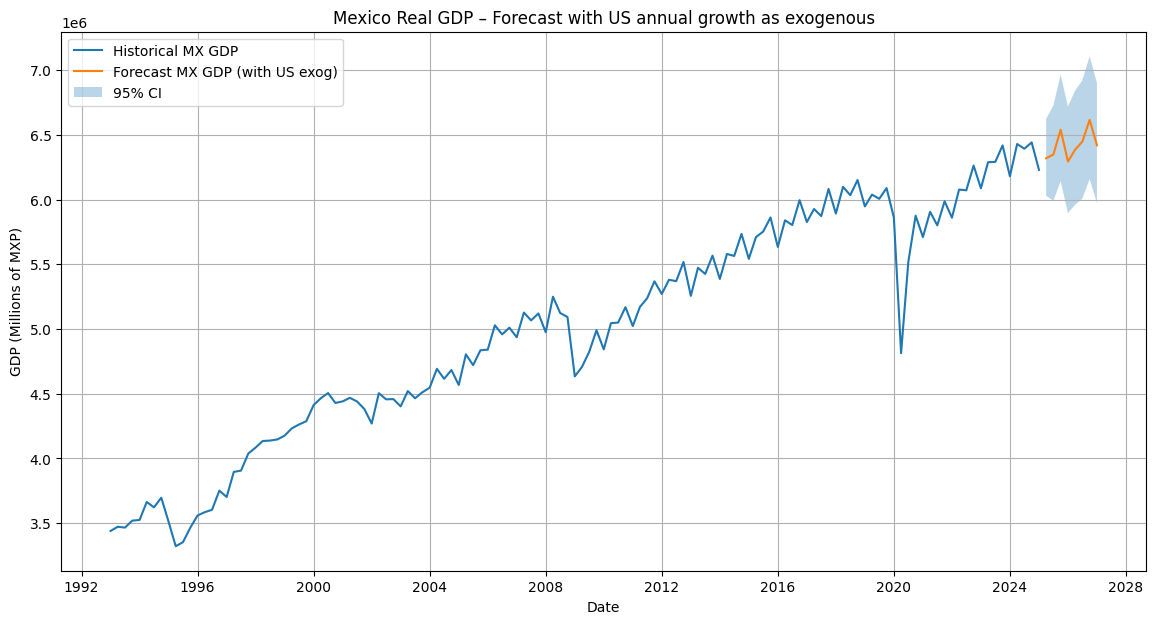

In [ ]:
# 1) Pronóstico de EEUU (mismo horizonte de México)
h = 8  # 8 trimestres ~ resto 2025 + 2026
us_fore = result.get_forecast(steps=h)             # <-- 'result' es tu modelo EEUU
us_log_fore = us_fore.predicted_mean

# 2) Construir US_yoy futura: Δ4 logY_t = logY_t - logY_{t-4}
# Para los primeros 4 pasos, el rezago t-4 es histórico; para >4, usa pronóstico laggeado.
us_log_all = pd.concat([usgdpdf['logY'], us_log_fore])  # histórico + forecast
us_yoy_all = us_log_all.diff(4)
US_yoy_fore = us_yoy_all.loc[us_log_fore.index]         # toma solo las fechas futuras

# 3) Pronóstico de México con exógena futura
mx_fore = result_mx_exog.get_forecast(steps=h, exog=US_yoy_fore.values.reshape(-1,1))
mx_log_mean = mx_fore.predicted_mean
mx_ci = mx_fore.conf_int(alpha=0.05)

# Volver a niveles
mx_mean = np.exp(mx_log_mean)
mx_ci_lower = np.exp(mx_ci.iloc[:,0])
mx_ci_upper = np.exp(mx_ci.iloc[:,1])

# Graficar
plt.figure(figsize=(14,7))
plt.plot(mxgdpdf.index, mxgdpdf['MXGDP'], label='Historical MX GDP')
plt.plot(mx_mean.index, mx_mean, label='Forecast MX GDP (with US exog)')
plt.fill_between(mx_mean.index, mx_ci_lower, mx_ci_upper, alpha=0.3, label='95% CI')
plt.title('Mexico Real GDP – Forecast with US annual growth as exogenous')
plt.xlabel('Date'); plt.ylabel('GDP (Millions of MXP)')
plt.grid(True); plt.legend(); plt.show()


The result amaze me because it's impresive how our economies are very correlated (for surprise of no one) both are strongly very close. This because both we are out first economic ally, Mexico export almots 80% of its exportations to US and for US Mexico are now comertial partner #1 dethroning China, this because we are neighbors and we have the comertial treatment NAFTA.

Our economies are almost 1:1 this is clearly backed by the result:

- US_yoy = 0.9651

This cam be traduced that for each percentual point of the annual US GDP grows the mexican almost also grow 1 (0.96).

Also:

- AR(1) = Remains positively significant to the Mexican GDP in the same range as without the explanatory variable in a range of about 70%. So it indicates this is not casual its persistent to the last quarter.

- MA Seasonal L4 keeps very similar with the same effect.

All coefficients are statistically significative and the relation with US is not casually is a causal relationship, it can be seen in numbers and in our daily life.

# Notes

### Notes class Oct 30th

- All ARIMA has 3 variables and SARIMA 4
- Those series with time, dayly etc... these seasonality models do not apply. Just to weekly monthly and annualy series because we need the data from the current month and the last same months like a historial
- d minus and D major is used to know:

D = # of differences in the Y series in order it gets stational

Conditions for stationality:
- Mean is vert similar over time
- Standard deviation is very similar over time
- Dicky-Fuller test: when the null hypothesis is rejected we can consider the series as stationary.

if d=1, I'm using the first difference of the series (use the thumb nail rule of the log).

If we apply the log to the series the first difference is % of change from a period to other (monthly, annual etc...)

Rule of thumb: Get the log and check if the first difference is stationary or not. Is very rare d = 2.

If d=2 I'm using the second difference. The second diffence is the first difference of the first difference. If we apply the log we get the first difference and we get the % month to month and the second difference get the first difference of the first difference and we get how change the difference.

It's like the acceleration, the second derivate that gives you the acceleration.

D1 = # of seasonal differences what we do to make the series be stational

If D=1 and d=0, and the series is logY this difference is the growth annual % period to period observations for example january to january.

d1D1logY = Means basically how much monthly growth % period to period agains the growth of the last month %. The first derivate of the annual difference, it's the d1 for the D.







### Notes class November 3rd

Outline:

- Random Walk
- AR(1)
- AR MA (p,q) : d=0
- ARIMA (p,d,q)
- ARIMA-SARIMA (p,d,q) (P,D,Q,#p)
- SARIMAX => SARIMA con 1 o mas variables X(exogenas)


Calibracion modelo SARIMA con datos mensaules, trimestales o semestrales

0) Transformar variables y a su log
1) Determinar las diferencias => Se usa dickyfuller test => Stationary
  Necesarias d y D de la variables logy
    d = 0/1 y D=0/1
  - Si d=0, D=1 ; logy => %Crecimiento anual
  - Si d=1, D-0 ; logy => %Crecimiento del perdiodo (mensual, trismestral, semanal, etc...).
  - Si d=1, D=1 ; logy =>  Cambio en puntos porc. del periodo
  - Si d=0, D=0 ; logy => logy

2) Determinar valores de p,q,P,Q y #p(granuralidad)

Nota: La granuralidad se declara de acuerdo al periodo.

ARIMA: para D=1, d=0

difdSeaslogy = phi0 + phi1 (diffSeasLogY(t-1)) + phi1 x E(t-1) + Et





